# Liver Cirrhosis Outcome Classification

[![Kaggle](https://img.shields.io/badge/Kaggle-Competition-blue?logo=kaggle)](https://www.kaggle.com/competitions/ai-lab-turkiye-datathon-2025)

![Competition](/images/ai-lab.png)

**NOT:** The first version of the project (Notebook Version 1) achieved a higher **leaderboard score (LogLoss = 0.368)**, and therefore it was used as the official competition submission.

This notebook presents the technical approach of the second version, which addresses class imbalance and offers a more robust and realistic modeling strategy. **This version achieved a LogLoss score of 0.397 on the competition leaderboard.**

### 📝 Competition Overview

This project focuses on predicting patient outcomes in **liver cirrhosis** using clinical, demographic, and laboratory features. The goal is to build a **multi-class classification model** that assigns each patient to one of three outcomes:

- **C** – Censored (patient alive at `N_Days`)
- **CL** – Alive due to liver transplant
- **D** – Deceased at `N_Days`

The dataset contains **AI-generated clinical data** based on the original *Cirrhosis Patient Survival Prediction* dataset.  
It includes **20 features** and **35,000 rows**.

Both **train** and **test** sets are provided, and the target variable is **Status**.

---

### 📊 Evaluation Metric

Submissions are evaluated using **Multi-Class Logarithmic Loss**.

For each patient in the test set, you must predict a probability for all three outcomes:

- `Status_C`
- `Status_CL`
- `Status_D`


### 📂 Dataset Files

- **train.csv** — Contains features and the target label **Status**
- **test.csv** — Contains features only
- **sample_submission.csv** — Expected format for Kaggle submissions


### 📄 Submission Format

Your submission must contain a probability for each of the three possible outcomes:

```csv
id,Status_C,Status_CL,Status_D
7905,0.628084,0.034788,0.337128
7906,0.628084,0.034788,0.337128
7907,0.628084,0.034788,0.337128
```


### 🔍 Additional Dataset ([Original Cirrhosis Data](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction))

The competition organizers note that the train and test files were generated using a deep learning model trained on the **original Cirrhosis Patient Survival Prediction dataset**.
They explicitly encourage participants to use the original dataset to:

- Explore distributional differences

- Compare feature behavior

- Evaluate whether incorporating the original data improves model performance

For this purpose, I additionally loaded and analyzed the original Cirrhosis dataset.
**I used it only for exploratory analysis and additional testing**, without modifying the competition-provided train or test files. 

**All operations related to this data set were performed in  *[7.3. Original Cirrhosis Data - Pre-processing and Evaluation](#7.3.-Original-Cirrhosis-Data---Pre-processing-and-Evaluation)***



![Liver](/images/Liver.png)

### Why This Matters

Accurate prediction of cirrhosis outcomes can help healthcare providers:

- **Prioritize patients** who need immediate intervention
- **Optimize treatment** strategies based on predicted disease trajectory
- **Allocate medical resources** more effectively
- Improve overall patient care and outcomes

# 1. Data Loading & Initial Inspection

In [1]:
import numpy as np # Linear Algebra
import pandas as pd # Data Processing, CSV file I/O (e.g. pd.read_csv)

#Visulation
import matplotlib.pyplot as plt 
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from lightgbm import LGBMClassifier
import xgboost
from xgboost  import XGBClassifier

# Pre-Processing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Hyperparameter Search
from sklearn.model_selection import RandomizedSearchCV

# Evaluate
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix, log_loss,classification_report

# Model Save-Load
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
palette= "YlOrRd"

In [3]:
df_train = pd.read_csv("/kaggle/input/ai-lab-turkiye-datathon-2025/train.csv")
df_test = pd.read_csv("/kaggle/input/ai-lab-turkiye-datathon-2025/test.csv")

In [4]:
df_train.head(2)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,3021.0,NaN,14975.0,F,NaN,NaN,NaN,N,1.8,NaN,3.56,NaN,NaN,NaN,NaN,378.0,10.9,2.0,CL
1,1,2171.0,Placebo,22873.0,F,N,Y,N,N,0.5,216.0,3.77,52.0,674.0,71.0,188.0,316.0,9.6,4.0,C


In [5]:
df_test.head(2)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,2157.0,D-penicillamine,15730.0,F,N,N,Y,N,0.7,252.0,3.20,20.0,676.0,72.24,58.0,203.0,11.0,3.0
1,15001,2403.0,NaN,16071.0,F,NaN,NaN,NaN,S,0.5,NaN,3.81,NaN,NaN,NaN,NaN,286.0,10.4,3.0


# 2. Exploratory Data Analysis (EDA)

In [6]:
def check_df(dataframe, size=5):
    print('\n\n--- Shape -----------------------------------------------------------------------')
    print(dataframe.shape)
    print('\n\n--- Types -----------------------------------------------------------------------')
    print(dataframe.dtypes)
    print('\n\n--- Head ------------------------------------------------------------------------')
    print(dataframe.head(size))
    print('\n\n--- Tail ------------------------------------------------------------------------')
    print(dataframe.tail(size))
    print('\n\n--- NA --------------------------------------------------------------------------')
    print(dataframe.isnull().sum())
    print('\n\n--- INFO --------------------------------------------------------------------------')
    print(dataframe.info())

In [11]:
check_df(df_train)



--- Shape -----------------------------------------------------------------------
(15000, 20)


--- Types -----------------------------------------------------------------------
id                 int64
N_Days           float64
Drug              object
Age              float64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object


--- Head ------------------------------------------------------------------------
   id  N_Days             Drug      Age Sex Ascites Hepatomegaly Spiders  \
0   0  3021.0              NaN  14975.0   F     NaN          NaN     NaN   
1   1  2171.0          Placebo  22873.0   F       N            Y      

In [12]:
check_df(df_test)



--- Shape -----------------------------------------------------------------------
(10000, 19)


--- Types -----------------------------------------------------------------------
id                 int64
N_Days           float64
Drug              object
Age              float64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object


--- Head ------------------------------------------------------------------------
      id  N_Days             Drug      Age Sex Ascites Hepatomegaly Spiders  \
0  15000  2157.0  D-penicillamine  15730.0   F       N            N       Y   
1  15001  2403.0              NaN  16071.0   F     NaN          NaN     NaN   
2  15002  

In [7]:
target_col = 'Status'
num_cols = df_train.drop(columns=["id"]).select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [13]:
def target_distribution(dataframe,target_col):
    
    d = dataframe[target_col].value_counts().to_frame(name="Count") 
    
    plt.figure(figsize=(10, 6))
    
    sns.barplot(x=d.index, y='Count', data=d, palette=palette) 
    
    plt.title('Frequency Distribution of the Status Variable', fontsize=16)
    plt.xlabel('Status Categories', fontsize=12)
    plt.ylabel('Frekans (Count)', fontsize=12)
    plt.grid(axis='y', linestyle='--') 
    plt.tight_layout() 
    
    plt.show()

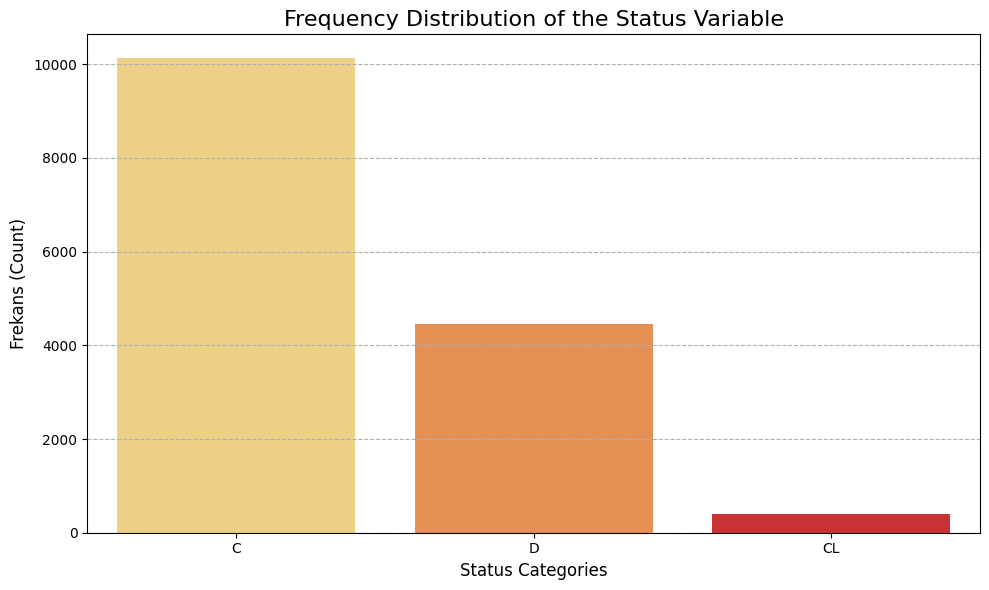

In [15]:
target_distribution(df_train,target_col) # Target variable data distribution

#### ❌ <font color="red">The class distribution is clearly unbalanced. </font>

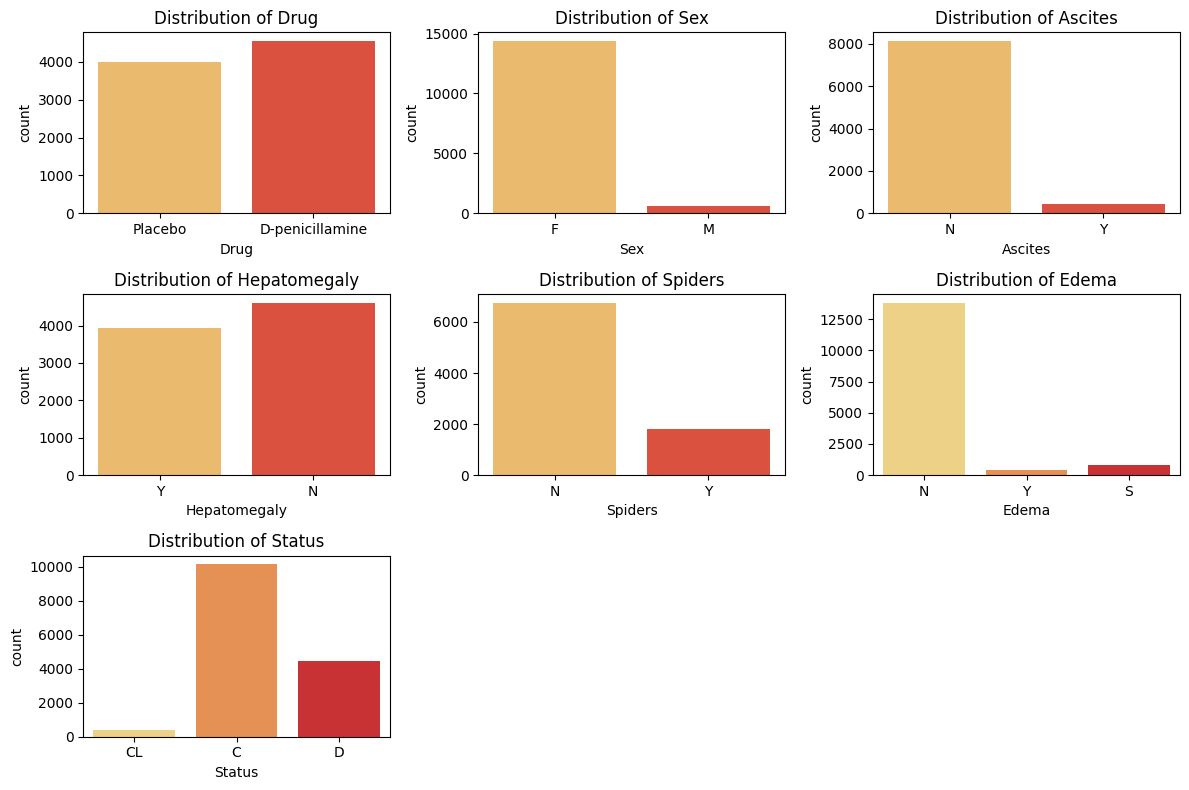

In [16]:
# Data distributions of categorical columns
plt.figure(figsize=(12, 8))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df_train, x=col, palette=palette)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## 3.1. Missing Value Analysis - Imputation

In this step, I checked the dataset for missing values and applied different imputation strategies for numerical and categorical features.

- **Numerical Columns**:
Missing values in numerical features were imputed using the **K-Nearest Neighbors Imputer (KNNImputer)**.
This method estimates each missing value based on the closest samples in the feature space, providing a more informed and data-driven imputation.


- **Categorical Columns**:
Missing values in **categorical features** were filled using the **mode** (most frequent value) computed from the training set.
This ensures consistency and prevents information leakage during model evaluation.

In [6]:
df_train.isnull().sum()

id                  0
N_Days              0
Drug             6446
Age                 0
Sex                 0
Ascites          6443
Hepatomegaly     6450
Spiders          6452
Edema               0
Bilirubin           0
Cholesterol      8313
Albumin             0
Copper           6545
Alk_Phos         6452
SGOT             6451
Tryglicerides    8360
Platelets         552
Prothrombin        30
Stage               0
Status              0
dtype: int64

In [8]:
def clean_impute(train_df,test_df, target_col, numeric_strategy="knn", knn_k=5):

    if target_col in num_cols: num_cols.remove(target_col)
    if target_col in cat_cols: cat_cols.remove(target_col)

    imputer = None # This imputer will be used in the test data to be loaded later.

    if numeric_strategy == "median":
        medians = train_df[num_cols].median()
        train_df[num_cols] = train_df[num_cols].fillna(medians)
        test_df[num_cols] = test_df[num_cols].fillna(medians)

    elif numeric_strategy == "knn":
        imputer = KNNImputer(n_neighbors=knn_k)
        train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
        test_df[num_cols]  = imputer.transform(test_df[num_cols])

    modes = train_df[cat_cols].mode().iloc[0]
    train_df[cat_cols] = train_df[cat_cols].fillna(modes)
    test_df[cat_cols] = test_df[cat_cols].fillna(modes)

    return train_df, test_df, imputer, modes #The mode and imputer will be used on different data sets.


In [9]:
train_filled,test_filled,imputer,modes = clean_impute(df_train,df_test,target_col)

In [10]:
train_filled.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [10]:
test_filled.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

####  <font color='green'>The nan values have been filled.</font>

## 3.2. Correlation Analysis

**All columns were encoded** into numerical format to compute a full correlation matrix and examine relationships across all features.

In [22]:
df_corr = train_filled.copy()

cat_cols = df_corr.select_dtypes(include="object").columns

le = LabelEncoder()
for col in cat_cols:
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

corr_matrix = df_corr.corr()

In [23]:
target_corr = corr_matrix["Status"].sort_values(ascending=False)
target_corr

Status           1.000000
Prothrombin      0.463775
Bilirubin        0.421421
Stage            0.389650
Copper           0.355607
SGOT             0.315513
Edema            0.311360
Hepatomegaly     0.280917
Spiders          0.265245
Ascites          0.247110
Age              0.176898
Alk_Phos         0.165684
Cholesterol      0.124359
Tryglicerides    0.109175
Sex              0.107420
Drug             0.021682
id               0.005965
Platelets       -0.197827
N_Days          -0.253962
Albumin         -0.293606
Name: Status, dtype: float64

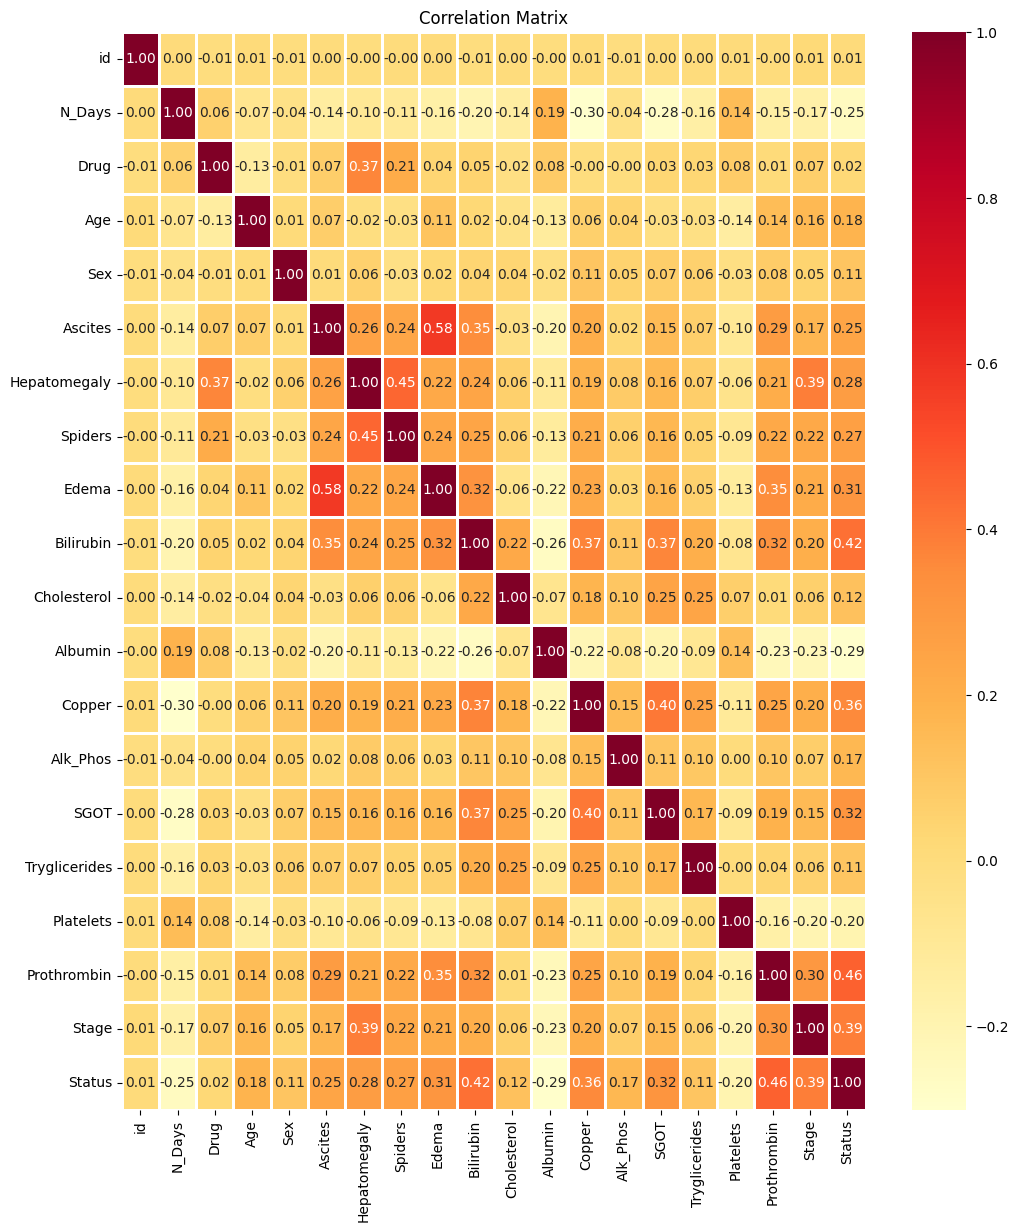

In [24]:
plt.figure(figsize=(12,14))
sns.heatmap(corr_matrix, fmt=".2f",linewidths=0.8, annot = True, cmap=palette)
plt.title("Correlation Matrix")
plt.show()

## 3.3. One-Hot Encoding

All categorical features, **except for the target variable (Status)**, were one-hot encoded for both the training and test datasets.

In [11]:
cat_cols = train_filled.select_dtypes(include="object").columns.drop("Status")

train_df = pd.get_dummies(train_filled, columns=cat_cols, drop_first=True)
test_df = pd.get_dummies(test_filled, columns=cat_cols, drop_first=True)

In [15]:
check_df(train_df)



--- Shape -----------------------------------------------------------------------
(15000, 21)


--- Types -----------------------------------------------------------------------
id                  int64
N_Days            float64
Age               float64
Bilirubin         float64
Cholesterol       float64
Albumin           float64
Copper            float64
Alk_Phos          float64
SGOT              float64
Tryglicerides     float64
Platelets         float64
Prothrombin       float64
Stage             float64
Status             object
Drug_Placebo         bool
Sex_M                bool
Ascites_Y            bool
Hepatomegaly_Y       bool
Spiders_Y            bool
Edema_S              bool
Edema_Y              bool
dtype: object


--- Head ------------------------------------------------------------------------
   id  N_Days      Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
0   0  3021.0  14975.0        1.8        257.4     3.56    57.0   1655.44   
1   1  2171.0  22873.0

In [16]:
check_df(test_df)



--- Shape -----------------------------------------------------------------------
(10000, 21)


--- Types -----------------------------------------------------------------------
id                  int64
N_Days            float64
Age               float64
Bilirubin         float64
Cholesterol       float64
Albumin           float64
Copper            float64
Alk_Phos          float64
SGOT              float64
Tryglicerides     float64
Platelets         float64
Prothrombin       float64
Stage             float64
Drug_Placebo         bool
Sex_M                bool
Ascites_Y            bool
Hepatomegaly_Y       bool
Spiders_Y            bool
Edema_N              bool
Edema_S              bool
Edema_Y              bool
dtype: object


--- Head ------------------------------------------------------------------------
      id  N_Days      Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
0  15000  2157.0  15730.0        0.7        252.0     3.20    20.0     676.0   
1  15001  2403.0

## 3.4. LabelEncoder

The target variable (**Status**) was **label-encoded**, converting its categories into numerical values (**0, 1, 2**).

**C,CL,D => 0,1,2**

In [12]:
le_target = LabelEncoder()
train_df["Status"] = le_target.fit_transform(train_df["Status"])

In [13]:
train_df.head()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Prothrombin,Stage,Status,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,0,3021.0,14975.0,1.8,257.4,3.56,57.0,1655.44,90.270,103.2,...,10.9,2.0,1,False,False,False,False,False,False,False
1,1,2171.0,22873.0,0.5,216.0,3.77,52.0,674.00,71.000,188.0,...,9.6,4.0,0,True,False,False,True,False,False,False
2,2,2698.0,22646.0,1.3,312.6,3.40,42.0,1597.84,71.218,100.2,...,10.4,3.0,0,False,False,False,False,False,False,False
3,3,1103.0,22280.0,5.6,245.2,2.23,18.0,790.00,179.800,123.4,...,13.0,4.0,2,False,False,True,True,True,False,True
4,4,2574.0,22336.0,1.1,287.4,3.40,131.0,728.00,97.650,70.0,...,10.0,4.0,0,True,False,False,True,True,False,False


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              15000 non-null  int64  
 1   N_Days          15000 non-null  float64
 2   Age             15000 non-null  float64
 3   Bilirubin       15000 non-null  float64
 4   Cholesterol     15000 non-null  float64
 5   Albumin         15000 non-null  float64
 6   Copper          15000 non-null  float64
 7   Alk_Phos        15000 non-null  float64
 8   SGOT            15000 non-null  float64
 9   Tryglicerides   15000 non-null  float64
 10  Platelets       15000 non-null  float64
 11  Prothrombin     15000 non-null  float64
 12  Stage           15000 non-null  float64
 13  Status          15000 non-null  int64  
 14  Drug_Placebo    15000 non-null  bool   
 15  Sex_M           15000 non-null  bool   
 16  Ascites_Y       15000 non-null  bool   
 17  Hepatomegaly_Y  15000 non-null 

## 3.5. Train–Test Preparation:  X and y

- The training features (**X_train**) were created by removing the `Status` and `id` columns, as id is not used for modeling.
- The target variable (**y_train**) consists of the `Status` column.
- For the test set, (**X_test**) was prepared by dropping only the `id` column.

In [15]:
X_train = train_df.drop(columns=["Status", "id"])
X_test = test_df.drop(columns=["id"])
y_train = train_df["Status"]

# Align
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

**🔗 Align Train and Test Features**

- The test set was **aligned** to the training set by using the training columns as reference.

- Any missing columns in the test set were filled with 0s, ensuring that both **training and test sets have the same number of features.**

In [16]:
print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))

X_train: (15000, 19)
X_test: (10000, 19)
y_train: (15000,)


##### ✔️ <font color="green">EQUAL FEATURE</font>

In [33]:
X_train[:2]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,3021.0,14975.0,1.8,257.4,3.56,57.0,1655.44,90.27,103.2,378.0,10.9,2.0,False,False,False,False,False,False,False
1,2171.0,22873.0,0.5,216.0,3.77,52.0,674.00,71.00,188.0,316.0,9.6,4.0,True,False,False,True,False,False,False


In [34]:
X_test[:2]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,2157.0,15730.0,0.7,252.0,3.20,20.0,676.0,72.24,58.0,203.0,11.0,3.0,False,False,False,False,True,False,False
1,2403.0,16071.0,0.5,331.6,3.81,73.6,1164.4,79.71,105.8,286.0,10.4,3.0,False,False,False,False,False,True,False


## 3.6. Scaling

- For **certain models**—**Logistic Regression, K-Nearest Neighbors, SVC, and MLP**—the features were standardized using **StandardScaler**.

- Copies of X_train and X_test were created so that unscaled data could still be used for models that do not require feature scaling.

In [22]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

## 3.7.SMOTE Oversampling

Because the **target variable was imbalanced**, **synthetic samples** were generated using the **SMOTE (Synthetic Minority Over-sampling Technique)** technique to balance the class distribution.

----
  
**SMOTE** creates synthetic samples for the minority class by interpolating between each minority instance and its nearest neighbors. This approach helps the model learn more generalizable decision boundaries and improves performance on underrepresented classes.


In [ ]:
# To resolve the version mismatch issue;   
!pip install --upgrade scikit-learn==1.2.2
!pip install --upgrade imbalanced-learn==0.11.0

In [39]:
from imblearn.over_sampling import SMOTE

In [41]:
# SMOTE only train set
smote_scaled = SMOTE(random_state=42, n_jobs=1)
X_train_scaled_res, y_train_res = smote_scaled.fit_resample(X_train_scaled, y_train)

smote_unscaled = SMOTE(random_state=42, n_jobs=1)
X_train_unscaled_res, y_train_res = smote_unscaled.fit_resample(X_train, y_train)

# The result of two smote operations will be the same for y_train. 
# Therefore, no other variable has been defined.

In [47]:
print("X_train: {}".format(X_train_scaled_res.shape))
print("X_test: {}".format(X_train_unscaled_res.shape))
print("y_train: {}".format(y_train_res.shape))

X_train: (30390, 19)
X_test: (30390, 19)
y_train: (30390,)


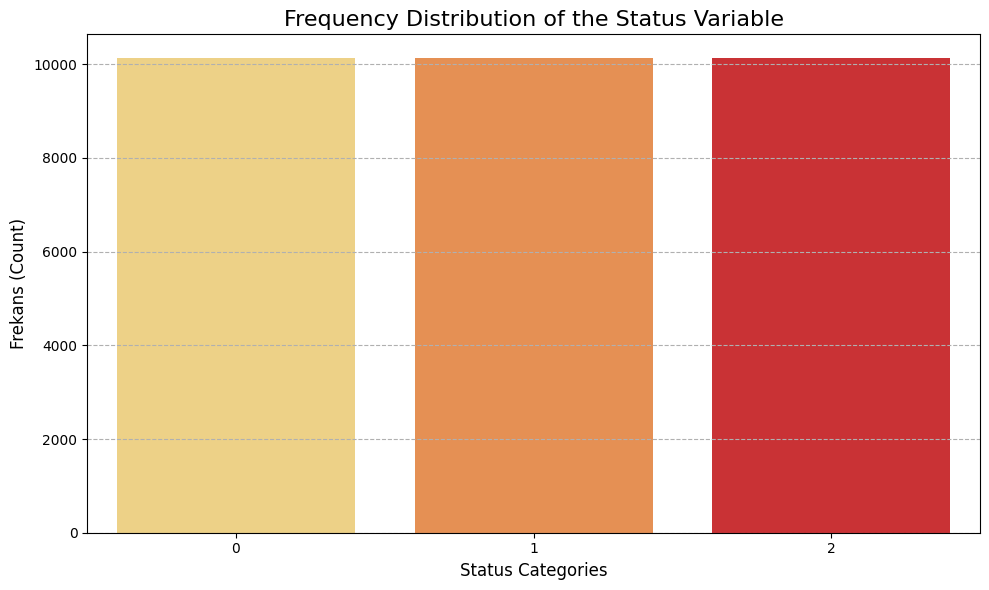

In [48]:
df_res = pd.DataFrame({"Status": y_train_res})

target_distribution(df_res, target_col)

##### ✔️ <font color="green">The class distribution has been balanced.</font>

# 4. Modelling

In [42]:
# Models to be trained with scaled data 
models_scaled = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial'),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=1000)
}

# Models to be trained with unscaled data.
models_raw = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier()
}

## 4.1. 📐 K-Fold : Baseline Model Training and Evaluation 

- Before hyperparameter tuning, all models were evaluated using their default settings.
- Since this is a Kaggle competition and the test set does not include target labels, **5-fold cross-validation** was used to estimate model performance.
- **Accuracy, precision, recall, and log loss** were computed for each model using the training data.

In [43]:
def evaluate_models(models, X, y, cv=5):
    results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():

        y_pred = cross_val_predict(model, X, y, cv=kf)
        y_proba = cross_val_predict(model, X, y, cv=kf, method='predict_proba')

        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average="weighted")
        rec = recall_score(y, y_pred, average="weighted")
        ll = log_loss(y, y_proba)

        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "LogLoss": ll,
        }

    return pd.DataFrame(results).T


In [44]:
print("Scaled models (distance/gradient based):")
df_scaled_results = evaluate_models(models_scaled, X_train_scaled_res, y_train_res)
print(df_scaled_results)

Scaled models (distance/gradient based):
                    Accuracy  Precision    Recall   LogLoss
LogisticRegression  0.687825   0.689591  0.687825  0.719577
KNN                 0.867325   0.868919  0.867325  1.334853
SVC                 0.823133   0.824201  0.823133  0.459413
MLP                 0.867851   0.866571  0.867851  0.365377


In [ ]:
print("\nRaw models (tree/boosting based):")
df_raw_results = evaluate_models(models_raw, X_train_unscaled_res, y_train_res)
print(df_raw_results)

In [46]:
print(df_raw_results)

                  Accuracy  Precision    Recall   LogLoss
DecisionTree      0.836821   0.835966  0.836821  5.843603
RandomForest      0.911320   0.910779  0.911320  0.293586
GradientBoosting  0.845245   0.844842  0.845245  0.409783
XGBoost           0.918230   0.918020  0.918230  0.226986
LightGBM          0.907799   0.907690  0.907799  0.263790


# 5. Hyperparameter Tuning


🥇 1. XGBoost

🥈 2. LightGBM

🥉 3. RandomForest

#### 🎯 Model Selection for Tuning

- Since the **competition is evaluated using multi-class log loss**, this metric was used to compare baseline models.

- The two models with the best log loss scores were selected for hyperparameter tuning.


#### 🔍 Hyperparameter Search

- Hyperparameter tuning was performed using **RandomizedSearchCV**, optimizing for **negative log loss with 5-fold cross-validation**. 

- This process explored a range of parameter combinations to identify the best-performing configuration for each selected model.

In [59]:
model_params = {
    "LightGBM": {
        "model": LGBMClassifier(
            objective="multiclass",       
            num_class=3,
            metric="multi_logloss", 
            random_state=42,               
            n_jobs=1,                      
            verbose=-1                      
        ),
        "params": {
            "n_estimators": [200,300,500],   #default=100    
            "learning_rate": [0.05, 0.07, 0.1], # default=0.1
            "num_leaves": [15,31,63],       # default=31       
            "min_child_samples": [20,30,40],     #default=20   
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            objective="multi:softprob",# multi-class probability 
            num_class=3,    
            eval_metric="mlogloss",# log-loss
            random_state=42,             
            n_jobs=-1,                    
            verbosity=0                  
        ),
        "params": {
            "n_estimators": [100,300, 400, 500],   
            "learning_rate": [0.03, 0.05, 0.1,0.3], # default=0.3    
            "max_depth": [3,4,5,6],   # default=6          
            "subsample": [0.7, 0.8, 0.9,1], # default=1     
            "colsample_bytree": [0.8, 1.0], # default=1
            "gamma": [0, 0.05, 0.1],   # default=0  
            "reg_lambda": [1,3,5],   # L2 regularization
        }
    }

}

- The smaller the LogLoss, the better the model.

- Sklearn reverses this and uses it as **negative log_loss** → attempts to maximise it.

- We use negative log_loss because RandomisedSearchCV / GridSearchCV automatically attempts to maximise it.

In [60]:
scores = []

for model_name, model_info in model_params.items():
    print(f"Running RandomizedSearchCV for {model_name}...")
    
    model = model_info["model"]
    param_grid = model_info["params"]
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=30,            
        scoring="neg_log_loss", 
        cv=5,
        verbose=1,
        n_jobs=1,
        random_state=42
    )
    
    random_search.fit(X_train_unscaled_res, y_train_res)
    
    scores.append([
        model_name,
        random_search.best_params_,
        -random_search.best_score_  
    ])


results_df = pd.DataFrame(scores, columns=["Model", "Best_Params", "CV_LogLoss"])
results_df = results_df.sort_values("CV_LogLoss")
results_df

Running RandomizedSearchCV for LightGBM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,Model,Best_Params,CV_LogLoss
0,LightGBM,"{'subsample': 0.8, 'num_leaves': 63, 'n_estima...",0.218144
1,XGBoost,"{'subsample': 1, 'reg_lambda': 3, 'n_estimator...",0.230044


In [61]:
results_df

,Model,Best_Params,CV_LogLoss
0,LightGBM,"{'subsample': 0.8, 'num_leaves': 63, 'n_estima...",0.218144
1,XGBoost,"{'subsample': 1, 'reg_lambda': 3, 'n_estimator...",0.230044


In [62]:
results_df["Best_Params"][0],results_df["Best_Params"][1]

({'subsample': 0.8,
  'num_leaves': 63,
  'n_estimators': 300,
  'min_child_samples': 30,
  'learning_rate': 0.07,
  'colsample_bytree': 0.8},
 {'subsample': 1,
  'reg_lambda': 3,
  'n_estimators': 500,
  'max_depth': 5,
  'learning_rate': 0.3,
  'gamma': 0.1,
  'colsample_bytree': 1.0})

# 6. 🏆 Final Model : Save, Create Submission File

- Among all tuned models, **LGBMClassifier** achieved the **best log loss score**.

- Using its optimized hyperparameters, the final model (best_model_final) was trained, evaluated, and saved for generating the competition submission.

In [65]:
best_params = {'subsample': 0.8,
  'num_leaves': 63,
  'n_estimators': 300,
  'min_child_samples': 30,
  'learning_rate': 0.07,
  'colsample_bytree': 0.8}

In [66]:
best_model_final =  LGBMClassifier(
            objective="multiclass",       
            num_class=3,
            metric="multi_logloss", 
            random_state=42,                                    
            verbose=-1)

In [67]:
best_model_final.fit(X_train_unscaled_res, y_train_res)

LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass',
               random_state=42, verbose=-1)

In [68]:
joblib.dump(best_model_final, "/kaggle/working/best_model_final.pkl")
print("Model saved: best_model_final.pkl")

Model saved: best_model_final.pkl


In [69]:
y_test_proba = best_model_final.predict_proba(X_test)
 
columns = ["Status_C", "Status_CL", "Status_D"]

proba_df = pd.DataFrame(y_test_proba, columns=columns)

proba_df["id"] = test_df["id"] 

proba_df = proba_df[["id", "Status_C", "Status_CL", "Status_D"]]

proba_df.to_csv("/kaggle/working/submission.csv", index=False)

print("submission.csv created.")

submission.csv created.


# 7. Model Loading and Evaluate

In [70]:
best_model_lgbm = joblib.load("/kaggle/working/best_model_final.pkl")
print("Model loaded successfully.")

Model loaded successfully.


In [71]:
# train set probability forecasts
y_pred_proba = best_model_lgbm.predict_proba(X_train)  
y_pred_class = best_model_lgbm.predict(X_train)       

In [72]:
y_pred_proba[:4]

array([[2.02065228e-01, 7.65789241e-01, 3.21455310e-02],
       [9.73261351e-01, 1.13706290e-02, 1.53680198e-02],
       [8.52527806e-01, 1.15318925e-02, 1.35940301e-01],
       [1.67542050e-03, 8.49223914e-05, 9.98239657e-01]])

In [73]:
y_pred_class[:4]

array([1, 0, 0, 2])

In [74]:
y_train[:4]

0    1
1    0
2    0
3    2
Name: Status, dtype: int64

## 7.1. LogLoss and Accuracy : on train data

**NOT:** This does not reflect the actual performance, but let us examine it.

In [75]:
ll = log_loss(y_train, y_pred_proba)
acc = accuracy_score(y_train, y_pred_class)

print(f"LogLoss: {ll:.6f}")
print(f"Accuracy: {acc:.4f}")

LogLoss: 0.270771
Accuracy: 0.8974


In [76]:
columns = ["Status_C", "Status_CL", "Status_D"]

print(classification_report(y_train, y_pred_class, target_names=columns))

              precision    recall  f1-score   support

    Status_C       0.91      0.94      0.93     10130
   Status_CL       0.67      0.67      0.67       407
    Status_D       0.88      0.81      0.84      4463

    accuracy                           0.90     15000
   macro avg       0.82      0.81      0.81     15000
weighted avg       0.90      0.90      0.90     15000



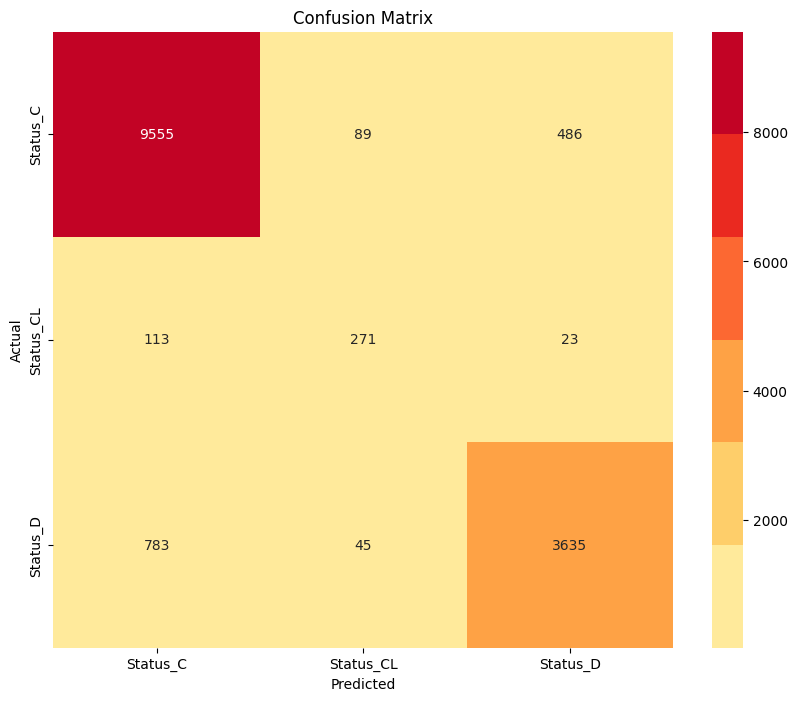

In [77]:
cm = confusion_matrix(y_train, y_pred_class)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(palette), xticklabels=columns, yticklabels=columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 7.2. SMOTE Data Evaluate

**NOT:** This does not reflect the actual performance, but let us examine it.

In [78]:
# train set probability forecasts
y_pred_proba_smote = best_model_lgbm.predict_proba(X_train_unscaled_res)  
y_pred_class_smote = best_model_lgbm.predict(X_train_unscaled_res)   

In [79]:
ll_res = log_loss(y_train_res, y_pred_proba_smote)
acc_res = accuracy_score(y_train_res, y_pred_class_smote)

print(f"LogLoss: {ll_res:.6f}")
print(f"Accuracy: {acc_res:.4f}")

LogLoss: 0.199014
Accuracy: 0.9374


In [80]:
columns = ["Status_C", "Status_CL", "Status_D"]

print(classification_report(y_train_res, y_pred_class_smote, target_names=columns))

              precision    recall  f1-score   support

    Status_C       0.91      0.94      0.93     10130
   Status_CL       0.96      0.98      0.97     10130
    Status_D       0.94      0.89      0.91     10130

    accuracy                           0.94     30390
   macro avg       0.94      0.94      0.94     30390
weighted avg       0.94      0.94      0.94     30390



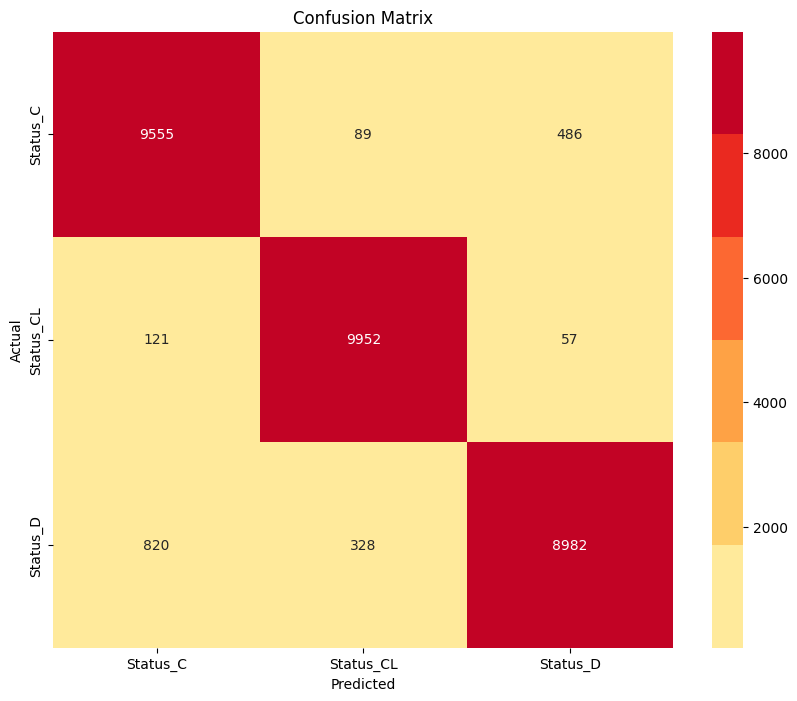

In [81]:
cm = confusion_matrix(y_train_res, y_pred_class_smote)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(palette), xticklabels=columns, yticklabels=columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 7.3. Original Cirrhosis Data - Pre-processing and Evaluation

- The second data set has been included for testing purposes only.

- All necessary procedures described above have been applied to the data in this section.

- However, the variables and functions defined above have been utilised. 

In [17]:
# Dataset load and EDA
df_second_test = pd.read_csv("/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv")
check_df(df_second_test)



--- Shape -----------------------------------------------------------------------
(418, 20)


--- Types -----------------------------------------------------------------------
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object


--- Head ------------------------------------------------------------------------
   ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N      

In [18]:
# Data Preprocessing
df_second_test = df_second_test.rename(columns={"ID": "id"}) # The ID column naming does not match; it has been corrected.

In [19]:
# The column order has been arranged.
train_order = df_train.columns

df_second_test = df_second_test.reindex(columns=train_order)

# column sequence check
print("df_second_test columns : ",df_second_test.columns)
print("df_train columns : ",train_order)

df_second_test columns :  Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')
df_train columns :  Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')


In [20]:
# nan imputation ;  imputer and modes have been calculated above.
def apply_imputation(new_test_df, num_cols, cat_cols, imputer, modes):
    new_test_df[num_cols] = imputer.transform(new_test_df[num_cols])
    new_test_df[cat_cols] = new_test_df[cat_cols].fillna(modes)
    return new_test_df

df_second_test = apply_imputation(df_second_test, num_cols, cat_cols, imputer, modes)
df_second_test.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [21]:
# one-hot-encoding
df_second_test = pd.get_dummies(df_second_test, columns=cat_cols, drop_first=True)
df_second_test.head(2)

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Prothrombin,Stage,Status,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,1,400.0,21464.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,...,12.2,4.0,D,False,False,True,True,True,False,True
1,2,4500.0,20617.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,...,10.6,3.0,C,False,False,False,True,True,False,False


In [22]:
# label encode 
le_test_target = LabelEncoder()
df_second_test["Status"] = le_test_target.fit_transform(df_second_test["Status"])

In [23]:
df_second_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              418 non-null    int64  
 1   N_Days          418 non-null    float64
 2   Age             418 non-null    float64
 3   Bilirubin       418 non-null    float64
 4   Cholesterol     418 non-null    float64
 5   Albumin         418 non-null    float64
 6   Copper          418 non-null    float64
 7   Alk_Phos        418 non-null    float64
 8   SGOT            418 non-null    float64
 9   Tryglicerides   418 non-null    float64
 10  Platelets       418 non-null    float64
 11  Prothrombin     418 non-null    float64
 12  Stage           418 non-null    float64
 13  Status          418 non-null    int64  
 14  Drug_Placebo    418 non-null    bool   
 15  Sex_M           418 non-null    bool   
 16  Ascites_Y       418 non-null    bool   
 17  Hepatomegaly_Y  418 non-null    boo

In [24]:
# Train–Test Preparation: X and y

X_second_test = df_second_test.drop(columns=["Status", "id"])
y_second_test = df_second_test["Status"]

# Align ; equal feature
_, X_second_test = X_train.align(X_second_test, join="left", axis=1, fill_value=0)

In [25]:
print("X_second_test: {}".format(X_second_test.shape))
print("y_second_test: {}".format(y_second_test.shape))

X_second_test: (418, 19)
y_second_test: (418,)


In [26]:
# Load model 
best_model_lgbm = joblib.load("/kaggle/input/liver-cirrhosis-classification-final-model/other/default/1/best_model_final.pkl")
print("Model loaded successfully.")

Model loaded successfully.


In [27]:
# probability forecasts
y_pred_proba_second = best_model_lgbm.predict_proba(X_second_test)  
y_pred_class_second = best_model_lgbm.predict(X_second_test) 

In [29]:
ll_second = log_loss(y_second_test, y_pred_proba_second)
acc_second = accuracy_score(y_second_test, y_pred_class_second)

print(f"LogLoss: {ll_second:.6f}")
print(f"Accuracy: {acc_second:.4f}")

LogLoss: 0.413021
Accuracy: 0.8445


In [30]:
columns = ["Status_C", "Status_CL", "Status_D"]

print(classification_report(y_second_test, y_pred_class_second, target_names=columns))

              precision    recall  f1-score   support

    Status_C       0.89      0.86      0.87       232
   Status_CL       0.69      0.72      0.71        25
    Status_D       0.81      0.84      0.83       161

    accuracy                           0.84       418
   macro avg       0.80      0.81      0.80       418
weighted avg       0.85      0.84      0.85       418



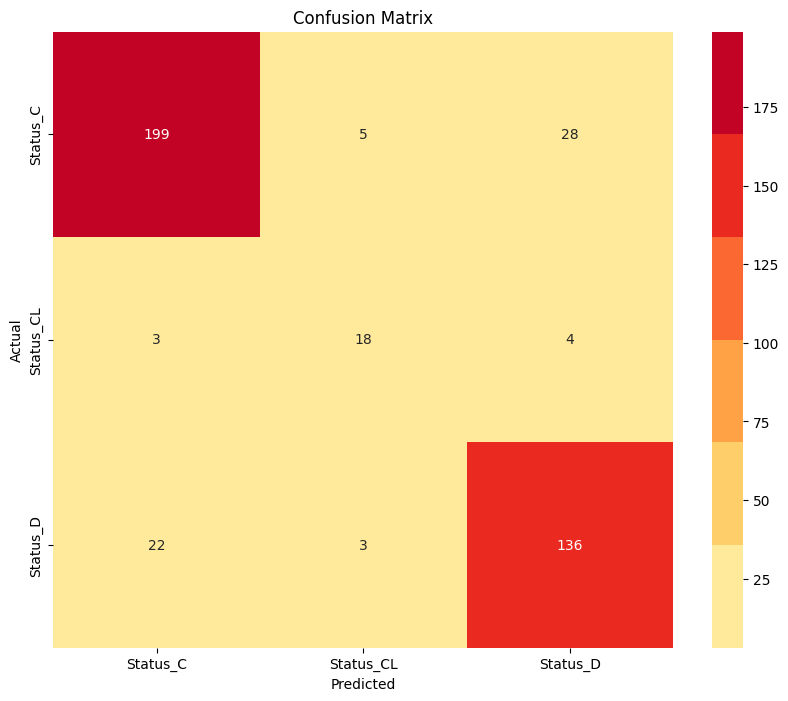

In [32]:
cm = confusion_matrix(y_second_test, y_pred_class_second)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(palette), xticklabels=columns, yticklabels=columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 🏁 Results

**The LGBMClassifier trained on SMOTE-augmented data was evaluated on the original train set:**

- **LogLoss**: 0.2708

- **Accuracy**: 0.897

- **Classification Report (F1-score)**:

  - **Status_C**: 0.93

  - **Status_CL**: 0.67

  - **Status_D**: 0.84

The model performs well overall, with lower performance on the minority class (Status_CL).